# Compare slope of ideal experiment with calculated values for dissipation

In [2]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:33093' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33093,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:41669,Total threads: 4
Dashboard: /proxy/40217/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41731,


In [3]:
trange = 360
t0 = 3700 + 15 * 24
data = tt.collect_data(
            exptname="debug_ideal-20",
            rawdata = ["KE_visc","KE_horvisc","PE_to_KE","KE","dKE_dt","KE_stress","KE_dia","KE_adv"],
            # rawdata = ["rho","u","v","ahh"],
            timerange = (t0,t0 + trange)
        ).sel(xb = slice(300,1000),yb = slice(-100,100))

loading KE_visc...	done.
loading KE_horvisc...	

Exception ignored in: <function CachingFileManager.__del__ at 0x15372536de10>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2627, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2590, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2034, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


done.
loading PE_to_KE...	done.
loading KE...	done.
loading dKE_dt...	done.
loading KE_stress...	done.
loading KE_dia...	done.
loading KE_adv...	done.


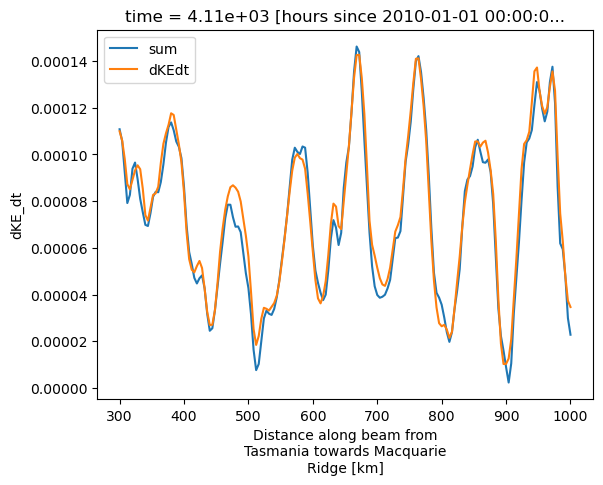

In [15]:
(data["KE_adv"] + data["PE_to_KE"]).isel(yb = 10,time = 50).sum("zl").plot(label = "sum")
(data["dKE_dt"]).isel(yb = 10,time = 50).sum("zl").plot(label = "dKEdt")

plt.legend()

0.00023682955076594086
-0.00016053487


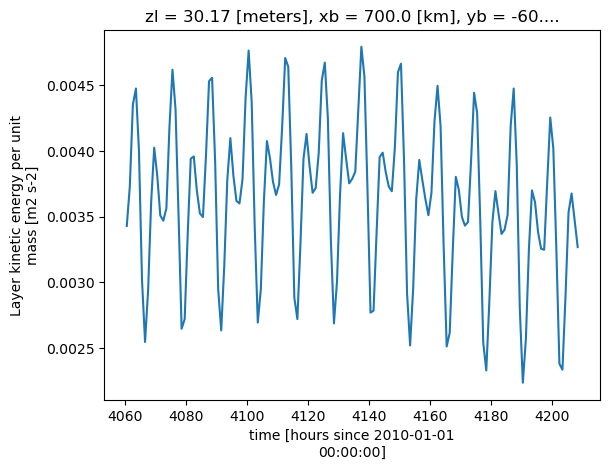

In [32]:
print(data.zl.isel(zl = 5).values * data["dKE_dt"].isel(yb = 10,xb = 100,zl = 5,time = slice(0,149)).integrate("time").values)
ke = data["KE"].isel(yb = 10,xb = 100,zl = 5,time = slice(0,149))
ke.plot()
print(ke[-1].values - ke[0].values)

In [26]:
data.time

<xarray.DataArray 'time' (time: 260)> Size: 2kB
array([4060.5, 4061.5, 4062.5, ..., 4317.5, 4318.5, 4319.5])
Coordinates:
  * time     (time) float64 2kB 4.06e+03 4.062e+03 ... 4.318e+03 4.32e+03
    zi       float64 8B ...
Attributes:
    long_name:      time
    calendar:       julian
    _FillValue:     nan
    axis:           T
    calendar_type:  JULIAN
    bounds:         time_bnds
    units:          hours since 2010-01-01 00:00:00

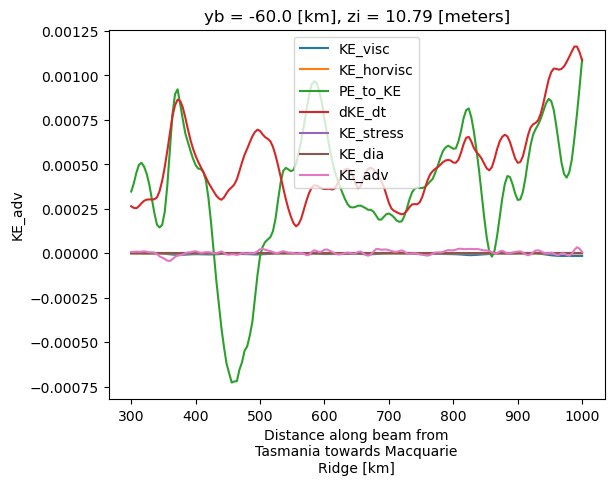

In [20]:
for k in ["KE_visc","KE_horvisc","PE_to_KE","dKE_dt","KE_stress","KE_dia","KE_adv"]:
# for k in ["KE_visc","KE_horvisc","KE_stress","KE_dia"]:
    data[k].isel(yb = 10).fillna(0).integrate("zl").mean("time").plot(label = k)

plt.legend()

## Collect data for the idealised experiment



In [ ]:
trange = 360
t0 = 3700 + 15 * 24
data = tt.collect_data(
            exptname="debug_ideal-20",
            rawdata = ["rho","u","v","ahh","KE_visc","KE_horvisc","PE_to_KE","KE"],
            # rawdata = ["rho","u","v","ahh"],
            timerange = (t0,t0 + trange)
        ).sel(xb = slice(300,1000),yb = slice(-100,100))

data = data.assign_coords(
    {"xb" : data.xb * 1000,
     "yb" : data.yb * 1000,
     "time":data.time * 3600
}).load()
N = tt.getN(data.rho).rename("N").mean("time")
efuncs = {}
efuncs["ideal-20"] = tt.ShootingVmodes(
    xr.merge(
        [
            data.bathy.rename("H"),
            N
        ]).sel(xb = slice(400000,405000),yb = slice(0,5000)).load().chunk({"xb":1,"yb":1})
)
phi = efuncs["ideal-20"].U.isel(xb = 0,yb = 0)
U = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * data.u).fillna(0).integrate("zl").load() 
V = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * data.v).fillna(0).integrate("zl").load()
ahh = data.ahh.load()
wavelength = efuncs["ideal-20"].Wavelength
N = N.isel(xb = 50,yb = 10) ## Do this for simplicity to match dimensions later for vertical integral

loading rho...	done.
loading u...	done.
loading v...	done.
loading ahh...	done.
loading KE_visc...	done.
loading KE_horvisc...	done.
loading PE_to_KE...	done.
loading KE...	done.


/jobfs/130820964.gadi-pbs/ipykernel_1841980/3944555532.py:25: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  U = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * data.u).fillna(0).integrate("zl").load()
/jobfs/130820964.gadi-pbs/ipykernel_1841980/3944555532.py:26: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  V = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * data.v).fillna(0).integrate("zl").load()


/jobfs/130359644.gadi-pbs/ipykernel_1210714/1977818255.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


Text(0.5, 1.0, 'Horizontal KE dissipation')

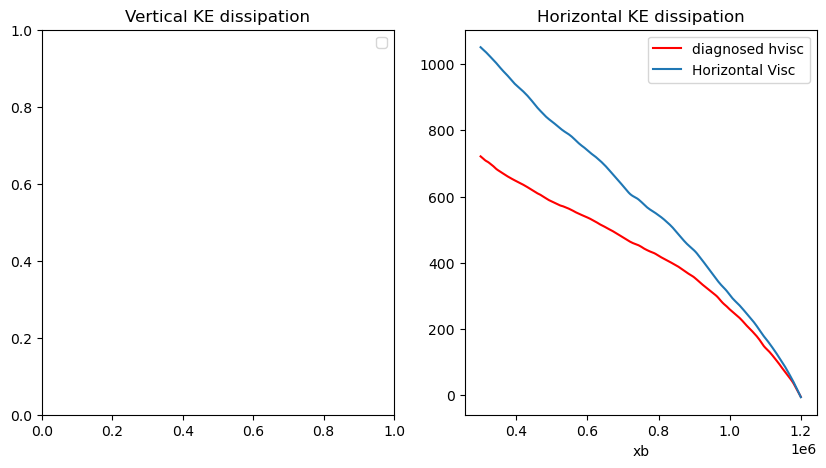

In [ ]:
def BeamIntegral(field):
    DT = field.time[-1].values - field.time[0].values
    d = field.fillna(0).sel(xb = slice(300000,1200000),yb = slice(-40000,40000)).integrate("time").integrate("yb") / DT
    return d.integrate("xb") - d.cumsum("xb") * 4000
fig,ax = plt.subplots(1,2,figsize = (10,5))
# BeamIntegral(-1 * data.KE_visc).sel(zl = slice(0,4000)).sum("zl").plot(ax = ax[0],label = "diagnosed vvisc",color = "red")
# BeamIntegral(
#     data.zl * np.abs(data.u.differentiate("zl")**2 + data.v.differentiate("zl")**2) * data.kvu
#     ).sel(zl = slice(0,4000)).sum("zl").plot(ax = ax[0],label = "Vertical Visc")
BeamIntegral(-1 * data.KE_horvisc).sel(zl = slice(0,4000)).sum("zl").plot(ax = ax[1],label = "diagnosed hvisc",color = "red")
BeamIntegral(
    data.zl * (data.u.differentiate("xb").differentiate("xb") + data.v.differentiate("yb").differentiate("yb"))**2 * ahh
    ).sel(zl = slice(0,4000)).sum("zl").plot(ax = ax[1],label = "Horizontal Visc")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Vertical KE dissipation")
ax[1].set_title("Horizontal KE dissipation")

# BeamIntegral(data.PE_to_KE).plot(label = "PE_to_KE")

### Self interaction term

## $ (u \cdot \nabla u_1) u_1 = u \cdot \phi(z) \phi'(z) \nu(x,y,t) \nabla \cdot \nu(x,y,t) $

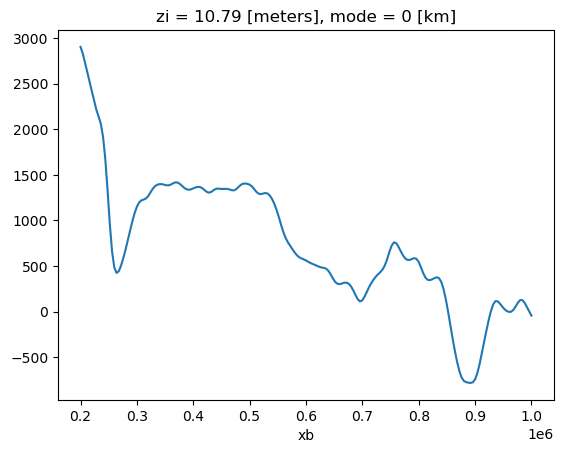

In [12]:
def self_interact(u,U,phi):
    return u * phi**2 * U * U.differentiate("xb")

SI_1 = self_interact(data.u,U.isel(mode = 0),phi.isel(mode = 0)) + self_interact(data.v,U.isel(mode = 0),phi.isel(mode = 0))

BeamIntegral(SI_1).sel(zl = slice(0,5000)).integrate("zl").plot(label = "Self Interaction")

## Calculate energy flux from the existing eigenvalues for u,v

$ \large \tilde{P} = - \rho_0 \int \left( \frac{\partial \tilde{U}}{\partial t} - f \tilde{V} \right) dx + \tilde{P_0}(y,t) $

$ \large b= \frac{1}{\rho_0} \partial_z P $

$ \large b= \frac{1}{\rho_0} \partial_z \phi \tilde{P} $

where $\phi$ is the horizontal velocity eigenfunction, and tildes denote eigenvalues, i.e the horizontal components of velocities s.t $u = \tilde{u}(x,y,t) \phi(z)$

This cell is quite a mess since I had to deal with dividing by zeroes in some areas, since N and phi do vary in x,y with topo outside flattened area. This will need revising for other cases where N and phi change also along beam path

In [10]:
rot = 7.3e-5
data.lat.mean("yb").mean("xb").values
2 * rot * np.sin(-44 * np.pi / 180)

-0.0001014201220870136

In [27]:
def EnergyFlux(U,V,phi,N):
    f = -0.0001
    rho0 = 1034
    P = rho0 * xr.DataArray(
        data = - scipy.integrate.cumulative_trapezoid(
                (U.differentiate("time") - f * V),
                x = U.xb,
                initial = 0
            ),
        dims = U.dims,
        coords = U.coords
    )
    P -= P.mean("xb")
    b_z = phi.differentiate("zl")
    b2_N2 = (phi.differentiate("zl")**2 / N**2).fillna(0)
    b2_N2 = b2_N2.where(np.isfinite(b2_N2),0).integrate("zl")
    APE = 0.5 * (
        (P / rho0)**2 * b2_N2
        ).integrate("yb")
    H = 5000 # Should be bathy!
    ubt = data.u.fillna(0).integrate("zl")/H
    vbt = data.v.fillna(0).integrate("zl")/H    
    
    KE = 0.5 * (U**2).integrate("yb")
    KE += 0.5 * (V**2).integrate("yb")
    KE_bt = 0.5 * (H * ubt**2).integrate("yb")
    KE_bt += 0.5 * (H * vbt**2).integrate("yb")
    EF_along = (U * P)
    EF_across = (V * P)

    return xr.merge([P.rename("P"),APE.rename("APE"),KE.rename("KE"),EF_along.rename("EF_along"),EF_across.rename("EF_across"),KE_bt.rename("KE_bt")]).fillna(0)
# DT = U.time[-1] - U.time[0]
D = ahh * (U.differentiate("xb").differentiate("xb") + V.differentiate("yb").differentiate("yb"))**2
energies = (
    EnergyFlux(U,V,phi,N)
).load()

# energies = xr.merge([energies,D.rename("Dissipation")]).load()

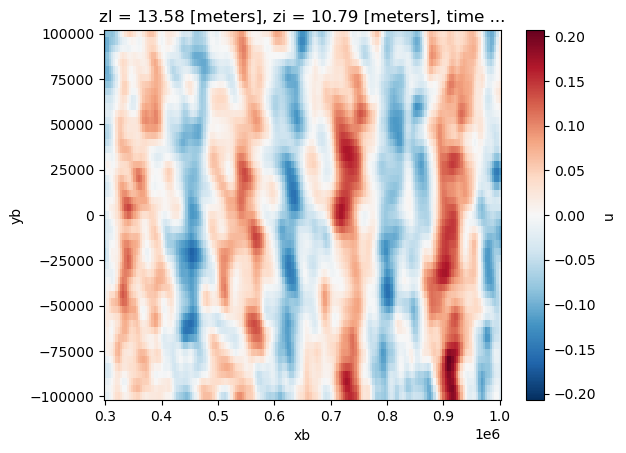

In [4]:
data.u.isel(time = 5,zl = 2).plot()

## Collect each energy source and sink for a box and integrate

In [28]:
xextent = [300000,700000]
yextent = [-100000,100000]
tmax = 149
# fig,ax = plt.subplots(1,figsize = (15,15))
EF_east = -1 * energies.EF_along.sel(
    xb = xextent[-1],method = "nearest"
    ).sel(yb = slice(yextent[0],yextent[1])).integrate("yb").sum("mode")
EF_west = energies.EF_along.sel(
    xb = xextent[0],method = "nearest"
    ).sel(yb = slice(yextent[0],yextent[1])).integrate("yb").sum("mode")
EF_north = -1 * energies.EF_across.sel(
    yb = yextent[-1],method = "nearest"
    ).sel(xb = slice(xextent[0],xextent[1])).integrate("xb").sum("mode")
EF_south = energies.EF_across.sel(
    yb = yextent[0],method = "nearest"
    ).sel(xb = slice(xextent[0],xextent[1])).integrate("xb").sum("mode")
PEtoKE = (data.PE_to_KE * data.zl).fillna(0).sel(
    xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])
    ).sum("zl").integrate("yb").integrate("xb")
KE_visc = (data.KE_visc * data.zl).fillna(0).sel(
    xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])
    ).sum("zl").integrate("yb").integrate("xb")
KE_horvisc = (data.KE_horvisc * data.zl).fillna(0).sel(
    xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])
    ).sum("zl").integrate("yb").integrate("xb")
# KE_stress = (data.KE_stress * data.zl[0]).fillna(0).sel(
#     xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])
#     ).integrate("yb").integrate("xb")
rho_bottom = 1037
rho_surface = 1034
bottom_drag = (rho_bottom * 0.003 * (np.abs(data.u**3) + np.abs(data.v**3))
    ).sel(zl = 5000,method = "nearest").sel(
        xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])
        ).integrate("yb").integrate("xb")
surface_drag = (rho_surface * 6.1e-4 * (np.abs(data.u) + np.abs(data.v)) * (data.u**2 + data.v**2)).sel(zl = 5000,method = "nearest").sel(
        xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])
        ).integrate("yb").integrate("xb")
diss = (D * data.zl).fillna(0).integrate("xb").integrate("yb").integrate("zl").sum("mode").integrate("time").values


In [29]:
EF_east_tot = EF_east.isel(time = slice(0,tmax)).integrate('time').values
EF_west_tot = EF_west.isel(time = slice(0,tmax)).integrate('time').values
EF_north_tot = EF_north.isel(time = slice(0,tmax)).integrate('time').values
EF_south_tot = EF_south.isel(time = slice(0,tmax)).integrate('time').values
# diss = D.fillna(0).integrate("xb").integrate("yb").integrate("zl").sum("mode").integrate("time").values
# KE_stress_tot = KE_stress.isel(time = slice(0,tmax)).integrate('time').values
PEtoKE_tot = PEtoKE.isel(time = slice(0,tmax)).integrate('time').values
KE_visc_tot = KE_visc.isel(time = slice(0,tmax)).integrate('time').values
KE_horvisc_tot = KE_horvisc.isel(time = slice(0,tmax)).integrate('time').values
KE_stress_tot = KE_horvisc_tot * 0

bottom_drag_tot = bottom_drag.isel(time = slice(0,tmax)).integrate('time').values
surface_drag_tot = surface_drag.isel(time = slice(0,tmax)).integrate('time').values
delta_KE = 1034 * data.KE.fillna(0).sel(xb = slice(xextent[0],xextent[1]),yb = slice(yextent[0],yextent[1])).integrate("xb").integrate("yb").integrate("zl")
delta_KE = delta_KE.isel(time = -1) - delta_KE.isel(time = 0)
print("Integrate energy sources & sinks \nfor box in middle of beam  over \nx,y,z, and ~integer tidal periods")
print()
print(f"EF East:\t\t{EF_east_tot:.1e}")
print(f"EF West:\t\t{EF_west_tot:.1e}")
print(f"EF North:\t\t{EF_north_tot:.1e}")
print(f"EF South:\t\t{EF_south_tot:.1e}")
# print(f"Horizontal Diss.:   \t{diss:.1e}")
print(f"PEtoKE:   \t\t{PEtoKE_tot:.1e}")
print(f"KE_visc:   \t\t{KE_visc_tot:.1e}")
print(f"KE_horvisc:   \t\t{KE_horvisc_tot:.1e}")
# print(f"KE_stress:   \t\t{KE_stress_tot:.1e}")
print(f"bottom_drag:   \t\t{bottom_drag_tot:.1e}")
print(f"surface_drag:   \t{surface_drag_tot:.1e}")
print("==================================")
print(f"Sum of diagnosed:\t{(PEtoKE_tot + KE_visc_tot + KE_horvisc_tot + KE_stress_tot):.1e}")
print(f"dKE - sum:\t\t{(delta_KE - (PEtoKE_tot + KE_visc_tot + KE_horvisc_tot + KE_stress_tot)):.1e}")
print(f"Sum of our EF:   \t{(EF_east_tot + EF_west_tot + EF_north_tot + EF_south_tot):.1e}")

print(f"actual delta KE:\t{delta_KE:.1e}")
print("")
print("Missing terms? \nOr calculating these terms incorrectly?")


Integrate energy sources & sinks 
for box in middle of beam  over 
x,y,z, and ~integer tidal periods

EF East:		5.9e+14
EF West:		-2.9e+14
EF North:		-2.9e+14
EF South:		1.5e+14
PEtoKE:   		3.5e+14
KE_visc:   		-7.1e+12
KE_horvisc:   		-3.6e+11
bottom_drag:   		4.9e+12
surface_drag:   	1.5e+12
Sum of diagnosed:	3.4e+14
dKE - sum:		-3.4e+14
Sum of our EF:   	1.6e+14
actual delta KE:	-4.9e+12

Missing terms? 
Or calculating these terms incorrectly?


## Energy spin up??

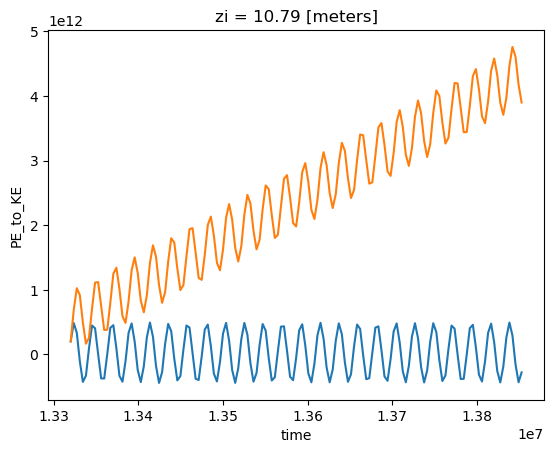

In [35]:
PEKE_timeseries = 1034 * data.PE_to_KE.fillna(0).sel(xb = slice(300000,800000),yb = slice(-75000,75000)).integrate("xb").integrate("yb").integrate("zl")
PEKE_timeseries.isel(time = slice(0,149)).plot()
PEKE_timeseries.isel(time = slice(0,149)).cumsum("time").plot()


3.7e+12
7.6e+10
-9.8e+13


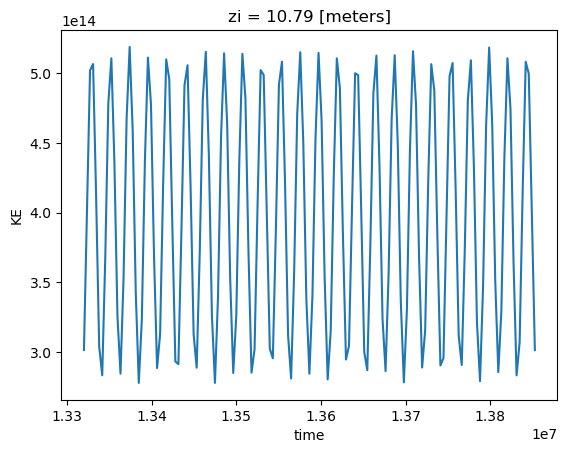

In [31]:
KE_timeseries = 1034 * data.KE.fillna(0).sel(xb = slice(300000,800000),yb = slice(-100000,100000)).integrate("xb").integrate("yb").integrate("zl")
print(f"{(KE_timeseries[0] - KE_timeseries[149]).values:.1e}")
print(f"{(KE_timeseries[0] - KE_timeseries[148]).values:.1e}")
print(f"{(KE_timeseries[0] - KE_timeseries[147]).values:.1e}")
KE_timeseries.isel(time = slice(0,149)).plot()

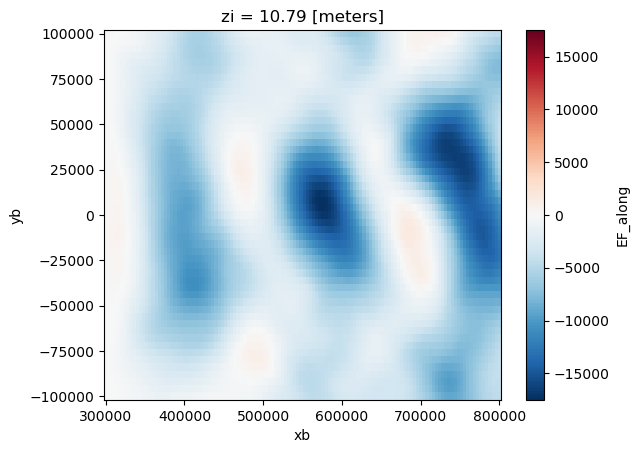

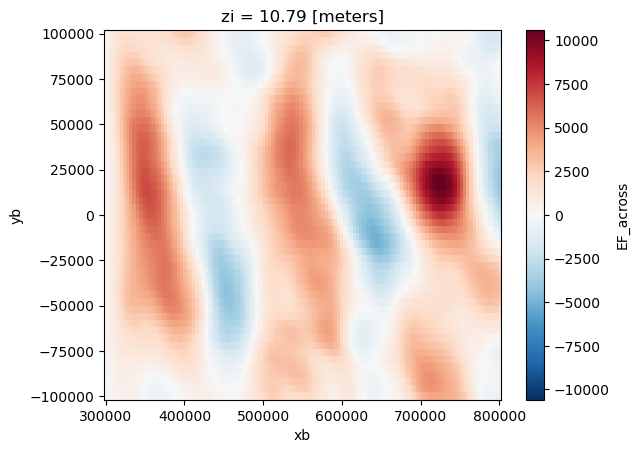

In [20]:
energies.EF_along.sel(xb = slice(300000,800000)).sum("mode").mean("time").plot()
plt.figure()
energies.EF_across.sel(xb = slice(300000,800000)).sum("mode").mean("time").plot()


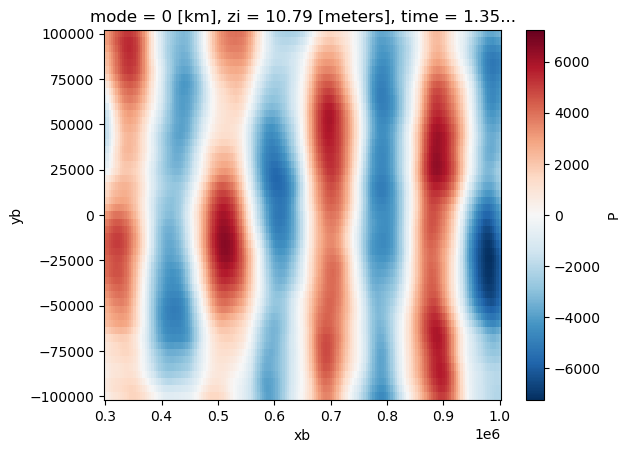

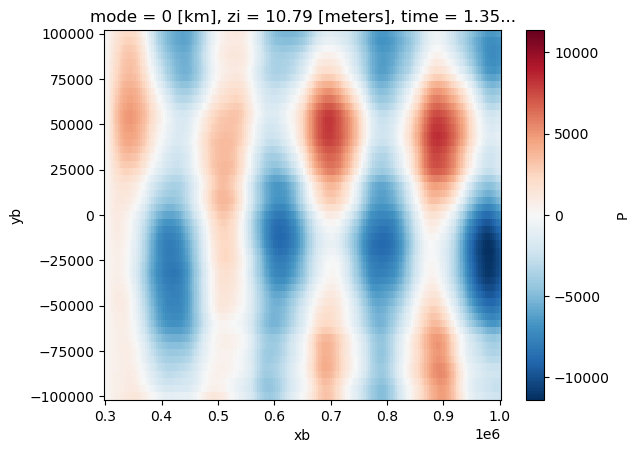

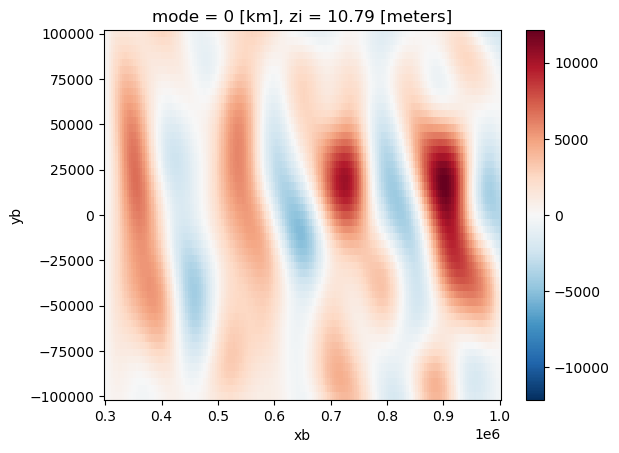

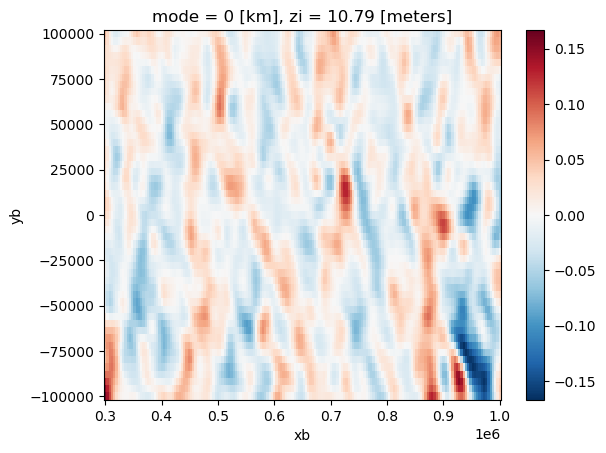

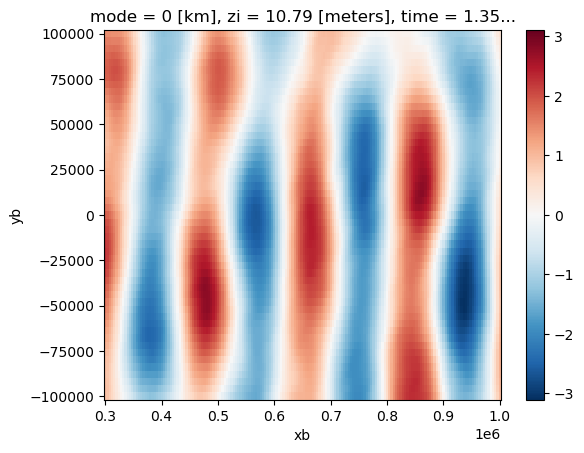

In [26]:
(energies.P - energies.P.mean("xb")).isel(mode = 0).isel(time = 50).plot()
plt.figure()
(energies.P).isel(mode = 0).isel(time = 50).plot()
plt.figure()
(energies.P *V).isel(mode = 0).mean("time").plot()
plt.figure()
V.isel(mode = 0).mean("time").plot()
plt.figure()
V.isel(mode = 0).isel(time = 50).plot()

## Rethink energy flux. Use only U V and no spatial integrals

$ \huge \frac{PE}{KE}=\frac{\omega^2-f^2}{\omega^2+f^2} $

$ \huge E_{tot} = KE \left( 1 +  \frac{\omega^2-f^2}{\omega^2+f^2}\right) $

$ \huge c_g^x = \frac{\overline{N} \overline{H}}{n\pi} \frac{\sqrt{\omega^2-f^2}}{\omega} $

$ \huge EF = c_g E_{tot}$

In [12]:
for i in range(1,100):
    if ((i * 12.42) % 1) < 0.1:
        print(i,i  *12.42)

12 149.04
24 298.08
31 385.02
43 534.06
50 621.0
62 770.04
74 919.08
81 1006.02
93 1155.06


In [30]:
omega = np.pi * 2 / (3600 * 12.42)
f = -0.0001

def cg(n = 1):
    Nbar= N.integrate("zl") / 5000
    H = 5000
    return ((Nbar * H) / (n * np.pi)) * np.sqrt(omega**2 - f**2) / omega

cg()

Etot = energies.KE * (1 + (omega**2 - f**2) / (omega**2 + f**2))

EF = -1 * cg() * Etot.isel(mode = 0) / (96000 * 5000)

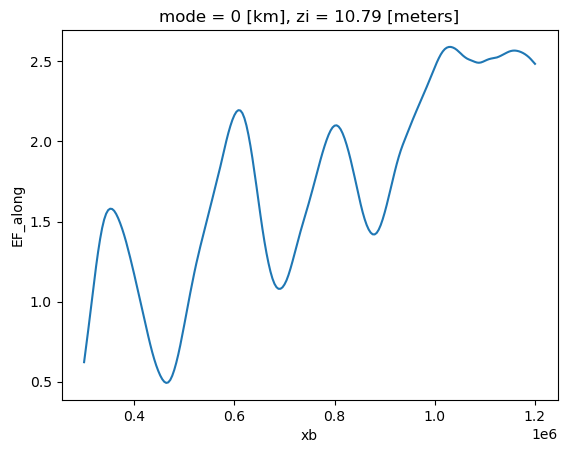

In [39]:
DT = 99 * 3600

EF_frompressure = energies.EF_along.isel(mode = 0).integrate("time").integrate("yb")
(EF_frompressure.sel(xb = slice(300000,1200000)) / (96000 * 5000 * DT)).plot()

Text(0, 0.5, 'Energy flux (W/m2)')

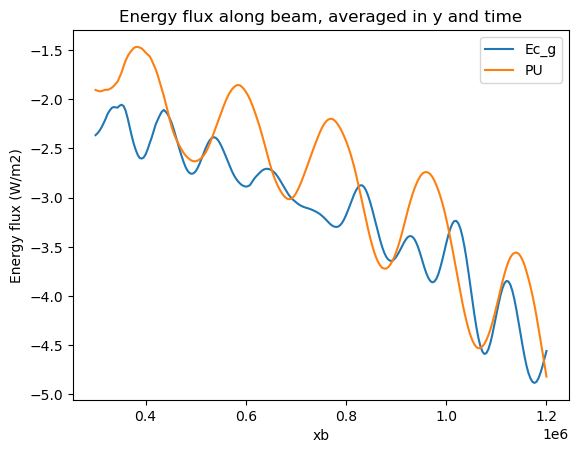

In [31]:
(1023 * EF.sel(xb = slice(300000,1200000)).mean("time")).plot(label = "Ec_g")

DT = 99 * 3600

EF_frompressure = energies.EF_along.isel(mode = 0).integrate("time").integrate("yb")
(EF_frompressure.sel(xb = slice(300000,1200000)) / (96000 * 5000 * DT)).plot(label = "PU")
plt.legend()
plt.title("Energy flux along beam, averaged in y and time")

plt.ylabel("Energy flux (W/m2)")

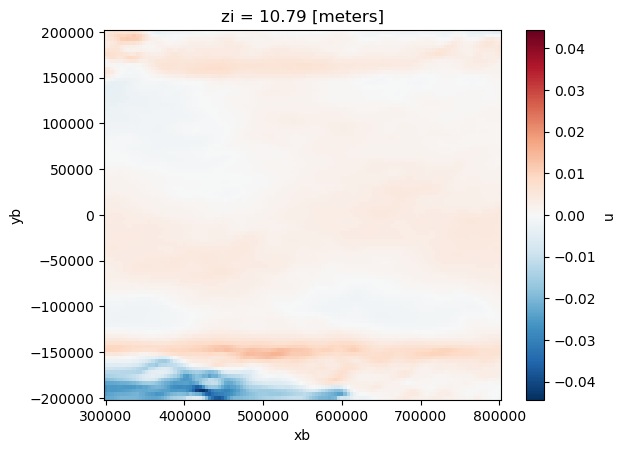

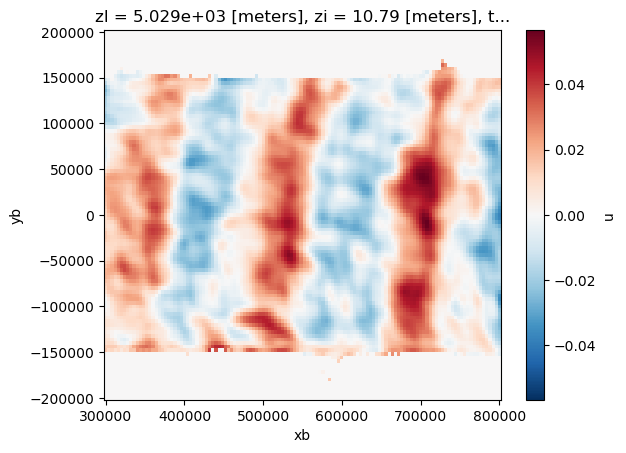

In [43]:
(data.u.fillna(0).sel(xb = slice(300000,800000)).integrate("zl").mean("time") / 5000).plot()
plt.figure()
(data.u.fillna(0).sel(xb = slice(300000,800000)).isel(zl = -5).isel(time = 50)).plot()
